# How batch-normalization affects drug response prediction?

3 datasets are tested that differ by the batch-effect removal approach:

1) Raw RNA-Seq data<br>
2) RNA-Seq normalized using Combat<br>
3) RNA-Seq normalized using source scaling<br>

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from time import time
from glob import glob
from pprint import pprint

import sklearn
import numpy as np
import pandas as pd

# Utils
from utils import scale_rna, plot_pca, load_rna, combat_

print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/vol/ml/apartin/projects/ncirepo/Normalization/RNASeqNorm


In [25]:
def src_from_cell_col(cell_name_col, verbose=False):
    """ Takes column that contains sample names, extract the source name, and returns the arr of source names.
    Prints value_counts if verbose=True. """
    src_names_arr = cell_name_col.map(lambda x: x.split('.')[0].lower())
    src_names_arr.name = 'source'
    if verbose: print(src_names_arr.value_counts())
    return src_names_arr

In [26]:
src_keep = ['ccle', 'nci60', 'ncipdm', 'gdc']
src_name_map = {'ccle': 'CCLE', 'nci60': 'NCI-60', 'ncipdm': 'NCI-PDM', 'gdc': 'GDC'}
fea_start_id = 1

# Load data

In [27]:
datadir = '../data'

In [28]:
rna_path = Path(datadir)/'combined_rnaseq_data_lincs1000'
rna = load_rna(datadir)
rna_org = rna.copy()

print(rna.shape)
src_from_cell_col(rna['CELL'], verbose=True);

(15196, 943)
gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        670
gcsi        357
nci60        60
Name: source, dtype: int64


In [29]:
# Extract sources which contain original RNA-Seq
src_names_arr = src_from_cell_col(rna['CELL'], verbose=False)
rna = rna.loc[ src_names_arr.isin(src_keep) ]
print(rna.shape)
src_from_cell_col(rna['CELL'], verbose=True);

(13357, 943)
gdc       11081
ncipdm     1198
ccle       1018
nci60        60
Name: source, dtype: int64


# Raw data

Explained variance by PCA components [1, 2]: [0.37752, 0.12893]


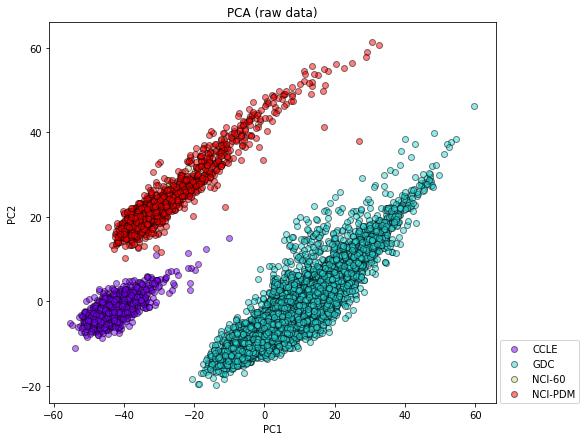

In [30]:
plot_pca(rna.iloc[:, fea_start_id:], components = [1, 2], figsize=(8,7),
         color_vector = rna['CELL'].map(lambda x: src_name_map[x.split('.')[0].lower()]),
         scale=True, title='PCA (raw data)');

# Source Scaling

Scaling ccle
Scaling gdc
Scaling nci60
Scaling ncipdm
(13357, 943)
Explained variance by PCA components [1, 2]: [0.29724, 0.06456]


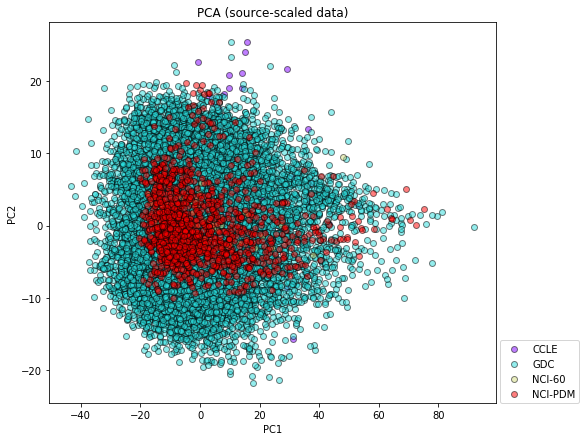

In [31]:
rna_src = scale_rna(rna, fea_start_id=fea_start_id, per_source=True)
print(rna_src.shape)

plot_pca(rna_src.iloc[:, fea_start_id:], components = [1, 2], figsize=(8,7),
         color_vector = rna['CELL'].map(lambda x: src_name_map[x.split('.')[0].lower()]),
         scale=True, title='PCA (source-scaled data)');

In [32]:
# rna_src.to_csv('rna_src.csv', index=False)

# Combat

Th source code for Python implementation of ComBat can be found in this repo: https://github.com/brentp/combat.py

In [33]:
# Data for combat
meta = src_from_cell_col(rna['CELL'], verbose=False).to_frame()
meta['CELL'] = rna['CELL']

found 4 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
Explained variance by PCA components [1, 2]: [0.29736, 0.06460]


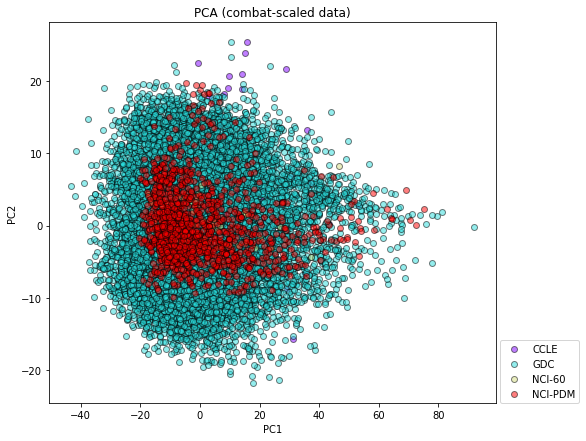

In [34]:
rna_combat = combat_(rna, meta, sample_col_name='CELL', batch_col_name='source')

plot_pca(rna_combat.iloc[:, fea_start_id:], components = [1, 2], figsize=(8,7),
         color_vector = rna['CELL'].map(lambda x: src_name_map[x.split('.')[0].lower()]),
         scale=True, title='PCA (combat-scaled data)');

In [35]:
# rna_combat.to_csv('rna_combat.csv', index=False)